TLS Point Cloud to Pano-image

In [4]:
!pip install laspy numpy opencv-python tqdm

In [6]:
import laspy
import numpy as np
from math import floor, pi
import cv2
from tqdm import tqdm
from multiprocessing import Process, shared_memory, cpu_count
import subprocess
import time

# ==== Constants ====
TILE_DIM = 512                   # Tile size for output (if tiling enabled)
PRECISION = 16                  # Subpixel precision
FACTOR = 2 ** PRECISION         # Scaling factor for subpixel precision
NUM_WORKERS = cpu_count()       # Max available CPU cores
SHARED_MEMORY_NAME = 'shared_canvas'

# ==== Parameters ====
INPUT_FILE = r"2025_05_22_AF_RIEGL_01.las"
OUTPUT_FILE = 'output.jpg'
NUM_THREADS = 1               # Number of parallel threads
IMAGE_HEIGHT = 4096*2
POINT_SIZE = 3
SCALE_COLORS = False
TILE_OUTPUT = False
FULL_RES = False


def create_shared_memory_array(data, name, dtype):
    start_time = time.time()
    print("Creating shared memory array...")
    shm = shared_memory.SharedMemory(create=True, size=data.nbytes, name=name)
    shared_array = np.ndarray(data.shape, dtype=dtype, buffer=shm.buf)
    shared_array[:] = data
    print(f"Shared memory array created in {time.time() - start_time:.2f} seconds.")
    return shm


def release_shared_memory(name):
    start_time = time.time()
    print("Releasing shared memory...")
    shm = shared_memory.SharedMemory(name=name)
    shm.close()
    shm.unlink()
    print(f"Shared memory released in {time.time() - start_time:.2f} seconds.")


def draw_points(start, length, canvas_shape, theta, phi, radius, color):
    print(f"Process drawing points from {start} to {start + length}...")
    shm = shared_memory.SharedMemory(name=SHARED_MEMORY_NAME)
    canvas = np.ndarray(canvas_shape, dtype=np.uint16, buffer=shm.buf)

    for i in tqdm(range(start, start + length)):
        cv2.circle(
            canvas,
            (theta[i], phi[i]),
            radius[i],
            color=(int(color[i][0]), int(color[i][1]), int(color[i][2])),
            thickness=cv2.FILLED,
            shift=PRECISION
        )
    print(f"Finished drawing points from {start} to {start + length}.")


def project_point_cloud():
    print("Starting point cloud projection...")

    if NUM_THREADS > NUM_WORKERS:
        raise SystemExit("Too many threads requested.")

    start_time = time.time()
    print(f"Reading input file: {INPUT_FILE}...")
    try:
        point_cloud = laspy.read(INPUT_FILE)
        print(f"Input file read successfully in {time.time() - start_time:.2f} seconds.")
    except FileNotFoundError as e:
        raise SystemExit(f"Input file not found: {e}")

    height, width = IMAGE_HEIGHT, IMAGE_HEIGHT * 2
    output_shape = (height, width, 3)
    total_points = point_cloud.header.point_count
    print(f"Total points in point cloud: {total_points}")

    background = np.zeros(output_shape, dtype=np.uint16)

    print("Calculating distances and spherical coordinates...")
    xyz = np.array([point_cloud.x, point_cloud.y, point_cloud.z])
    distances = np.linalg.norm(xyz, axis=0)
    distances_norm = (distances - distances.min()) / (distances.max() - distances.min())

    theta = ((width * FACTOR) -
             (((np.arctan2(point_cloud.y, point_cloud.x) + pi) / (2 * pi)) * width * FACTOR)).astype(np.uint64)
    phi = ((np.arccos(point_cloud.z / distances) / pi) * height * FACTOR).astype(np.uint64)
    radii = (FACTOR * POINT_SIZE * (1 - distances_norm) + 1).astype(np.uint64)

    colors = np.stack([point_cloud.blue, point_cloud.green, point_cloud.red], axis=-1).astype(np.uint16)
    if SCALE_COLORS:
        colors *= 256

    del point_cloud  # Free memory

    print("Sharing canvas memory...")
    shm_canvas = create_shared_memory_array(background, SHARED_MEMORY_NAME, np.uint16)
    del background

    print("Launching parallel drawing processes...")
    processes = []
    for i in range(NUM_THREADS):
        start = floor(i * total_points / NUM_THREADS)
        end = floor((i + 1) * total_points / NUM_THREADS)
        p = Process(target=draw_points, args=(start, end - start, output_shape, theta, phi, radii, colors))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    print("All drawing processes completed.")

    print("Reading final image from shared memory...")
    final_image = np.ndarray(output_shape, dtype=np.uint16, buffer=shm_canvas.buf)
    if not FULL_RES:
        final_image = (final_image / 256).astype(np.uint8)

    print(f"Saving image to {OUTPUT_FILE}...")
    try:
        cv2.imwrite(OUTPUT_FILE, final_image)
        print("Image saved successfully.")
    except cv2.error as e:
        print(f"Failed to save image: {e}")

    if TILE_OUTPUT:
        print("Tiling output...")
        subprocess.run([
            'kubi', '-s', '2048',
            '-co', f'tile_size={TILE_DIM}', '-co', 'depth=onetile',
            '-co', 'overlap=0', '-co', 'layout=google',
            '-co', 'suffix=.jpg[Q=75]', '-f', 'r', 'l', 'u', 'd', 'f', 'b',
            OUTPUT_FILE, OUTPUT_FILE.replace('.jpg', '.dz')
        ])
        print("Tiling completed.")

    release_shared_memory(SHARED_MEMORY_NAME)


if __name__ == '__main__':
    project_point_cloud()

Starting point cloud projection...
Reading input file: 2025_05_22_AF_RIEGL_01.las...
Input file read successfully in 1.94 seconds.
Total points in point cloud: 20714438
Calculating distances and spherical coordinates...
Sharing canvas memory...
Creating shared memory array...
Shared memory array created in 0.79 seconds.
Launching parallel drawing processes...
Process drawing points from 0 to 20714438...


100%|██████████| 20714438/20714438 [02:04<00:00, 166625.78it/s]


Finished drawing points from 0 to 20714438.
All drawing processes completed.
Reading final image from shared memory...
Saving image to output.jpg...
Image saved successfully.
Releasing shared memory...
Shared memory released in 0.00 seconds.


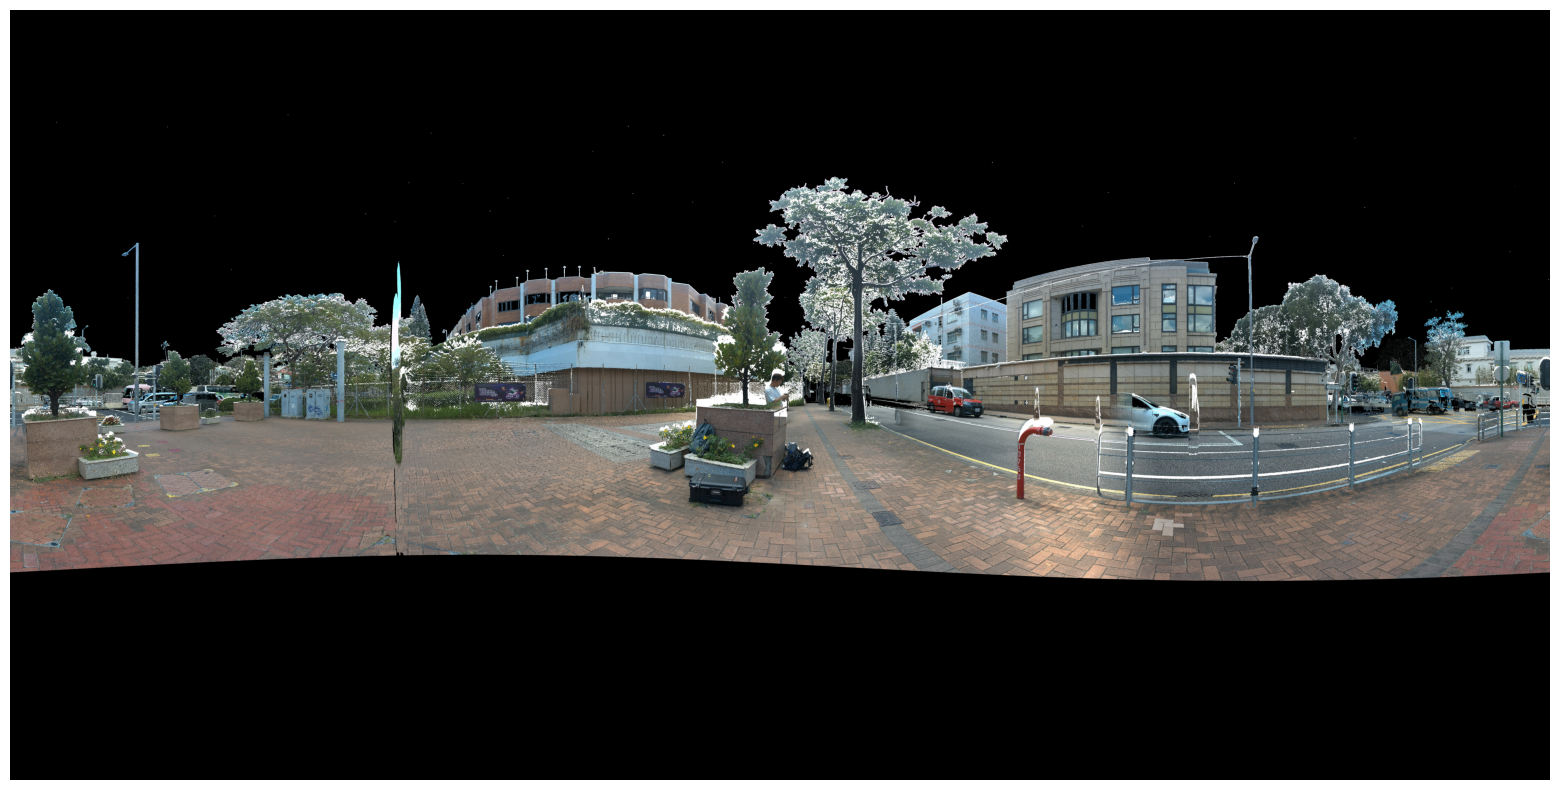

In [12]:
import matplotlib.pyplot as plt

def plot_jpg_directly(image_path):
    """Read and display the JPG image directly using Matplotlib with a 2:1 aspect ratio."""
    image = cv2.imread(image_path)  # Read the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(20, 10))  # Width: 20, Height: 10
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide axis
    plt.show()

plot_jpg_directly('/content/output.jpg')